# **ResNet** Ablation Study
***
***

#### Import Libraries

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend, regularizers, initializers, models

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load Data

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [ ]:
ds_info.features["label"].num_classes

2

In [ ]:
ds_info.features["label"].names

['cat', 'dog']

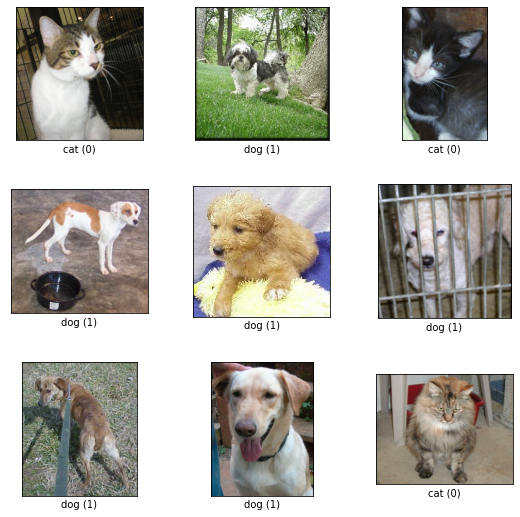

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

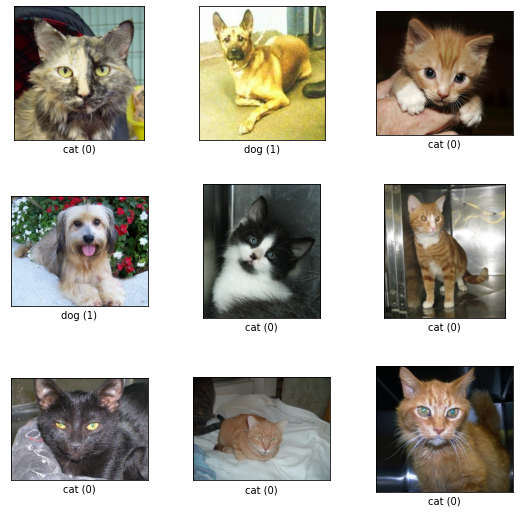

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

### Input Normalization

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 1) ResNet 기본 블록 구성하기
***

In [ ]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [ ]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

In [ ]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=2, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

## 2) ResNet-34, ResNet-50 Complete Model
***

### ResNet-34

In [ ]:
resnet_34 = build_resnet(input_shape=(224,224,3), is_50=False, activation='relu', name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

### ResNet-50

In [ ]:
resnet_50 = build_resnet(input_shape=(224,224,3), is_50=True, activation='relu', name='ResNet_50')
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 112, 112, 64  256        ['conv2d_36[0][0]']              
 ormalization)                  )                                                         

## 3) 일반 네트워크(plain network) 만들기
***

In [ ]:
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [ ]:
def build_plain(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### Plain-34

In [ ]:
plain_34 = build_plain(input_shape=(224,224,3), is_50=False, activation='relu', name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        369

In [ ]:
plain_50 = build_plain(input_shape=(224,224,3), is_50=True, activation='relu', name='Plain_50')
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_122 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 56, 56, 64)        416

## 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
***
* 모델 학습
* 비교

In [ ]:
BATCH_SIZE = 32
EPOCH = 10

In [ ]:
# 데이터 정의

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

#### Plain-34

In [ ]:
# Plain-34 학습


plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 100s 129ms/step - loss: 4.0563 - accuracy: 0.4964 - val_loss: 3.8458 - val_accuracy: 0.4892
Epoch 2/10
581/581 [==============================] - 71s 123ms/step - loss: 3.8213 - accuracy: 0.5031 - val_loss: 3.8644 - val_accuracy: 0.4830
Epoch 3/10
581/581 [==============================] - 71s 122ms/step - loss: 3.8178 - accuracy: 0.5045 - val_loss: 3.8414 - val_accuracy: 0.4972
Epoch 4/10
581/581 [==============================] - 71s 122ms/step - loss: 3.8156 - accuracy: 0.5031 - val_loss: 3.8125 - val_accuracy: 0.4840
Epoch 5/10
581/581 [==============================] - 71s 122ms/step - loss: 3.8112 - accuracy: 0.5044 - val_loss: 3.8090 - val_accuracy: 0.4900
Epoch 6/10
581/581 [==============================] - 71s 122ms/step - loss: 3.8073 - accuracy: 0.5040 - val_loss: 3.8055 - val_accuracy: 0.4877
Epoch 7/10
581/581 [==============================] - 71s 122ms/step - loss: 3.8038 - accuracy: 0.5037 - val_loss: 3.8020 - val_accuracy: 0.

#### ResNet-34

In [ ]:
# ResNet-34 학습


resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 95s 130ms/step - loss: 2.3544 - accuracy: 0.5031 - val_loss: 2.3518 - val_accuracy: 0.4888
Epoch 2/10
581/581 [==============================] - 74s 127ms/step - loss: 2.3499 - accuracy: 0.5031 - val_loss: 2.3479 - val_accuracy: 0.4890
Epoch 3/10
581/581 [==============================] - 74s 127ms/step - loss: 2.3460 - accuracy: 0.5067 - val_loss: 2.3441 - val_accuracy: 0.4959
Epoch 4/10
581/581 [==============================] - 74s 127ms/step - loss: 2.3422 - accuracy: 0.5035 - val_loss: 2.3403 - val_accuracy: 0.4898
Epoch 5/10
581/581 [==============================] - 73s 127ms/step - loss: 2.3383 - accuracy: 0.5033 - val_loss: 2.3364 - val_accuracy: 0.4866
Epoch 6/10
581/581 [==============================] - 74s 127ms/step - loss: 2.3345 - accuracy: 0.5030 - val_loss: 2.3326 - val_accuracy: 0.4976
Epoch 7/10
581/581 [==============================] - 79s 137ms/step - loss: 2.3307 - accuracy: 0.5072 - val_loss: 2.3288 - val_accuracy: 0.4

#### Plain-50

In [ ]:
# Plain-50 학습


plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 120s 176ms/step - loss: 5.2478 - accuracy: 0.5426 - val_loss: 5.2273 - val_accuracy: 0.5293
Epoch 2/10
581/581 [==============================] - 111s 191ms/step - loss: 5.2241 - accuracy: 0.5368 - val_loss: 5.2169 - val_accuracy: 0.5472
Epoch 3/10
581/581 [==============================] - 99s 171ms/step - loss: 5.2608 - accuracy: 0.5442 - val_loss: 5.2187 - val_accuracy: 0.5357
Epoch 4/10
581/581 [==============================] - 99s 171ms/step - loss: 5.2142 - accuracy: 0.5403 - val_loss: 5.2123 - val_accuracy: 0.5156
Epoch 5/10
581/581 [==============================] - 99s 171ms/step - loss: 5.2092 - accuracy: 0.5415 - val_loss: 5.1986 - val_accuracy: 0.5390
Epoch 6/10
581/581 [==============================] - 100s 173ms/step - loss: 5.1938 - accuracy: 0.5261 - val_loss: 5.1851 - val_accuracy: 0.5470
Epoch 7/10
581/581 [==============================] - 100s 173ms/step - loss: 5.2411 - accuracy: 0.5507 - val_loss: 5.1767 - val_accuracy:

#### ResNet-50

In [ ]:
# ResNet-50 학습


resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 86s 114ms/step - loss: 6.0052 - accuracy: 0.5045 - val_loss: 5.9963 - val_accuracy: 0.4829
Epoch 2/10
581/581 [==============================] - 65s 111ms/step - loss: 5.9901 - accuracy: 0.5048 - val_loss: 5.9840 - val_accuracy: 0.4814
Epoch 3/10
581/581 [==============================] - 65s 111ms/step - loss: 5.9778 - accuracy: 0.5039 - val_loss: 5.9717 - val_accuracy: 0.4959
Epoch 4/10
581/581 [==============================] - 65s 112ms/step - loss: 5.9656 - accuracy: 0.5041 - val_loss: 5.9657 - val_accuracy: 0.4978
Epoch 5/10
581/581 [==============================] - 65s 112ms/step - loss: 5.9540 - accuracy: 0.5051 - val_loss: 5.9472 - val_accuracy: 0.4998
Epoch 6/10
581/581 [==============================] - 65s 113ms/step - loss: 5.9411 - accuracy: 0.5017 - val_loss: 5.9350 - val_accuracy: 0.4886
Epoch 7/10
581/581 [==============================] - 66s 113ms/step - loss: 5.9290 - accuracy: 0.5032 - val_loss: 5.9229 - val_accuracy: 0.4

### ResNet-34 vs Plain-34
* Loss 비교
* Accuracy 비교

ResNet-34 & Plain-34 Validation Loss

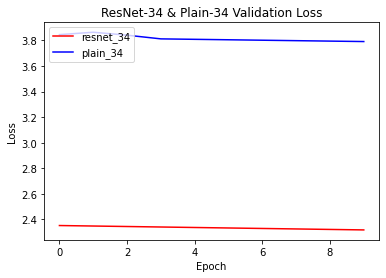

In [ ]:
import matplotlib.pyplot as plt


# ResNet-34, Plain-34 Validation Loss 시각화

plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_plain_34.history['val_loss'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

ResNet-34 & Plain-34 Validation Accuracy

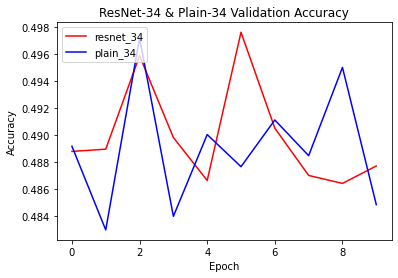

In [ ]:
# ResNet-34, Plain-34 Validation Accuracy 시각화

plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

### ResNet-50 vs Plain-50
* Loss 비교
* Accuracy 비교

ResNet-50 & Plain-50 Validation Loss

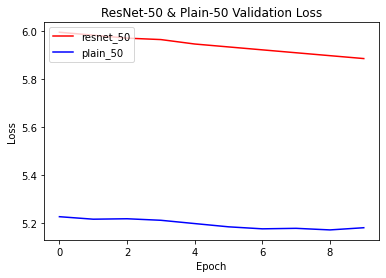

In [ ]:
# ResNet-50, Plain-50 Validation Loss 시각화

plt.plot(history_resnet_50.history['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

ResNet-50 & Plain-50 Validation Accuracy

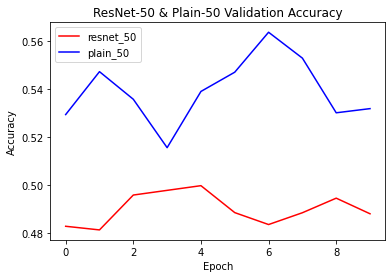

In [ ]:
# ResNet-50, Plain-50 Validation Accuracy 시각화

plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

ResNet-34 & Plain-34 & ResNet-50 & Plain-50 Validation Loss

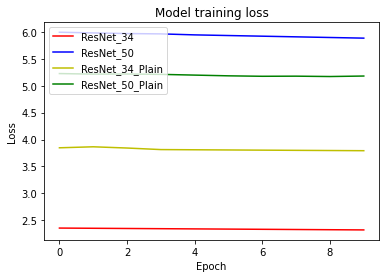

In [ ]:
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_resnet_50.history['val_loss'], 'b')
plt.plot(history_plain_34.history['val_loss'], 'y')
plt.plot(history_plain_50.history['val_loss'], 'g')
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','ResNet_34_Plain','ResNet_50_Plain'], loc='upper left')
plt.show()

ResNet-34 & Plain-34 & ResNet-50 & Plain-50 Validation Accuracy

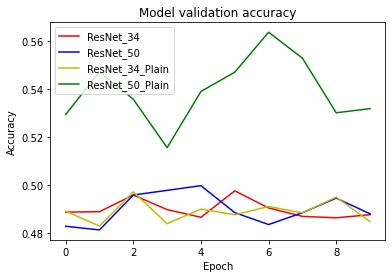

In [ ]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'y')
plt.plot(history_plain_50.history['val_accuracy'], 'g')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','ResNet_34_Plain','ResNet_50_Plain'], loc='upper left')
plt.show()